<a href="https://colab.research.google.com/github/rajlm10/D2L-Torch/blob/main/D2L_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l -q

     |████████████████████████████████| 82 kB 617 kB/s 
     |████████████████████████████████| 15.7 MB 24.4 MB/s 
     |████████████████████████████████| 11.2 MB 76.2 MB/s 
     |████████████████████████████████| 9.9 MB 76.9 MB/s 
     |████████████████████████████████| 61 kB 8.2 MB/s 
     |████████████████████████████████| 930 kB 85.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import os
import torch
import torchvision
from d2l import torch as d2l
from torch import nn

In [ ]:
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar', '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [ ]:
def read_voc_images(voc_dir, is_train=True):
  """Read all VOC feature and label images."""
  txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation','train.txt' if is_train else 'val.txt') 
  mode = torchvision.io.image.ImageReadMode.RGB
  with open(txt_fname, 'r') as f: 
    images = f.read().split()
  features, labels = [], []
  for i, fname in enumerate(images):
    features.append(torchvision.io.read_image(os.path.join( voc_dir, 'JPEGImages', f'{fname}.jpg')))
    labels.append(torchvision.io.read_image(os.path.join( voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
  return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

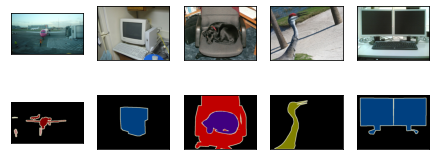

In [ ]:
n=5
imgs = train_features[0:n] + train_labels[0:n] 
imgs = [img.permute(1,2,0) for img in imgs] 
d2l.show_images(imgs, 2, n);

In [ ]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
[0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
                
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [ ]:
def voc_colormap2label():
  """Build the mapping from RGB to class indices for VOC labels.""" 
  colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
  for i, colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label


def voc_label_indices(colormap, colormap2label):
  """Map any RGB values in VOC labels to their class indices.""" 
  colormap = colormap.permute(1, 2, 0).numpy().astype('int32') 
  idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2])
  return colormap2label[idx]

In [ ]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y.shape

torch.Size([281, 500])

#Preprocessing

In previous experiments images are rescaled to fit the modelʼs required input shape. However, in semantic segmentation, doing so requires rescaling the predicted pixel classes back to the original shape of the input image. Such rescaling may be inaccurate, especially for segmented regions with different classes. To avoid this issue, we crop the image to a fixed shape instead of rescaling. Specifically, using random cropping from image augmentation, we crop the same area of the input image and the label.

In [ ]:
def voc_rand_crop(feature, label, height, width): 
  """Randomly crop both feature and label images.""" 
  #Rect is y1,x1,h,w
  rect = torchvision.transforms.RandomCrop.get_params(feature, (height, width))
  feature = torchvision.transforms.functional.crop(feature, *rect) 
  label = torchvision.transforms.functional.crop(label, *rect)
  return feature, label

10


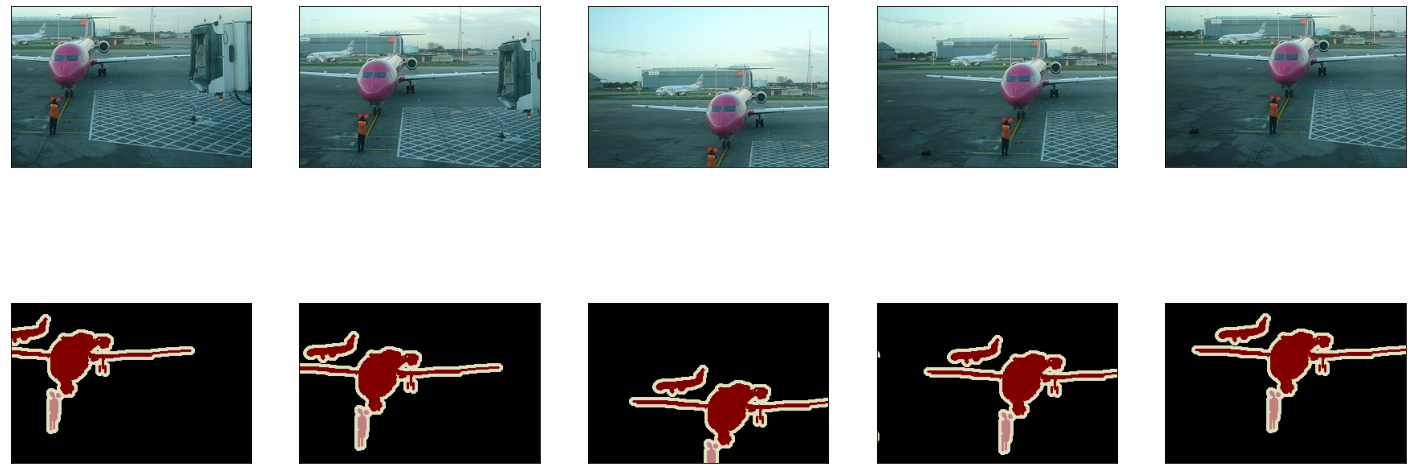

In [ ]:
imgs = []
for _ in range(n):
  imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1, 2, 0) for img in imgs] 

print(len(imgs))

d2l.show_images(imgs[::2] + imgs[1::2], 2, n,scale=5);

#The Dataset

Since some images in the dataset have a smaller size than the output size of random cropping,these examples are filtered out by a custom filter function.

In [ ]:
class VOCSegDataset(torch.utils.data.Dataset):
  """A customized dataset to load the VOC dataset."""
  def __init__(self, is_train, crop_size, voc_dir): 
    self.transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    self.crop_size = crop_size
    features, labels = read_voc_images(voc_dir, is_train=is_train) 
    self.features = [self.normalize_image(feature) for feature in self.filter(features)] 
    self.labels = self.filter(labels)
    self.colormap2label = voc_colormap2label()
    print('read ' + str(len(self.features)) + ' examples')

  def normalize_image(self, img):
    return self.transform(img.float() / 255)

  def filter(self, imgs):
    return [img for img in imgs if (img.shape[1] >= self.crop_size[0] and img.shape[2] >= self.crop_size[1])]

  def __getitem__(self, idx):
    feature, label = voc_rand_crop(self.features[idx], self.labels[idx],*self.crop_size)
    return (feature, voc_label_indices(label, self.colormap2label))

  def __len__(self):
    return len(self.features)

In [ ]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir) 
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [ ]:
import multiprocessing

batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,drop_last=True,num_workers=multiprocessing.cpu_count())

for X, Y in train_iter: 
  print(X.shape)
  print(Y.shape) 
  break

torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


In [ ]:
def load_data_voc(batch_size, crop_size):
  """Load the VOC semantic segmentation dataset.""" 
  voc_dir = d2l.download_extract('voc2012', os.path.join('VOCdevkit', 'VOC2012'))
  num_workers = multiprocessing.cpu_count()
  train_iter = torch.utils.data.DataLoader(VOCSegDataset(True, crop_size, voc_dir), batch_size, shuffle=True, drop_last=True, num_workers=num_workers)
  test_iter = torch.utils.data.DataLoader( VOCSegDataset(False, crop_size, voc_dir), batch_size, drop_last=True, num_workers=num_workers)
  return train_iter, test_iter

# Transposed Convolutions

In semantic segmentation that classifies at pixel-level, it will be convenient if the spatial dimensions of the input and output are the same. For example, the chan- nel dimension at one output pixel can hold the classification results for the input pixel at the same spatial position.

To achieve this, especially after the spatial dimensions are reduced by CNN layers, we can use another type of CNN layers that can increase (upsample) the spatial dimensions of intermedi- ate feature maps. In this section, we will introduce transposed convolution, which is also called fractionally-strided convolution (Dumoulin & Visin, 2016), for reversing downsampling operations by the convolution.

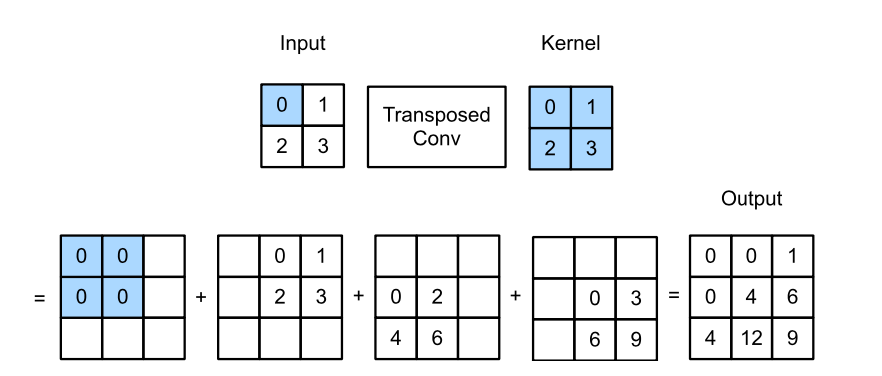

##Striding, Padding and Multiple Channels

For example, when specifying the padding number on either side of the height and width as 1, the first and last rows and columns will be removed from the transposed convolution output.

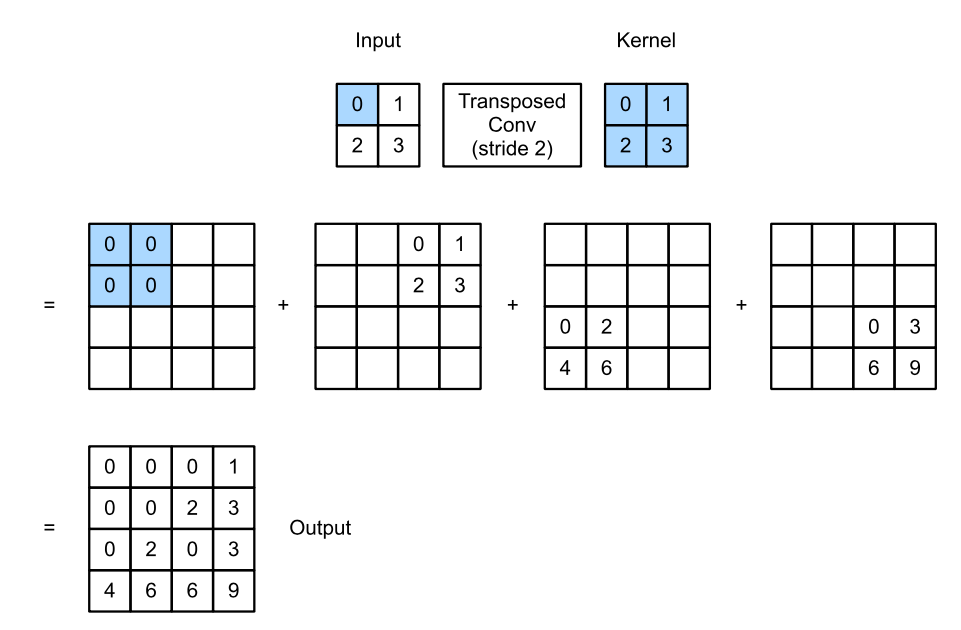

# The Model



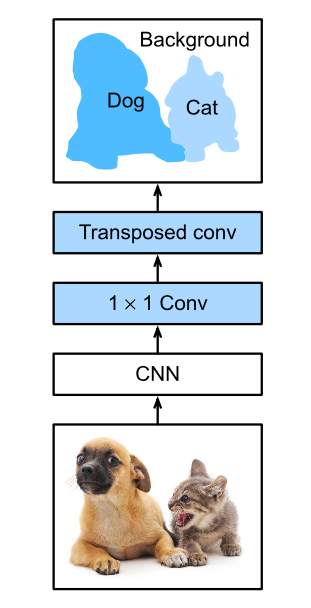

In [ ]:
pretrained_net = torchvision.models.resnet18(pretrained=True) 
list(pretrained_net.children())

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [ ]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])
X = torch.rand(size=(1, 3, 320, 480)) 
net(X).shape

torch.Size([1, 512, 10, 15])

In [ ]:
type(net)

torch.nn.modules.container.Sequential

Since (320−64+16×2+32)/32 = 10 and(480−64+16×2+32)/32 = 15,

**We construct a transposed convolutional layer with stride of 32, setting the height and width of the kernel to 64, the padding to 16. In general, we can see that for stride s, padding s/2 (assuming s/2 is an integer), and the height and width of the kernel 2s, the transposed convolution will increase the height and width of the input by s times.**

In [ ]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1)) 
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,kernel_size=64, padding=16, stride=32))

## Initializing Transposed Convolutional Layers

We already know that transposed convolutional layers can increase the height and width of feature maps. In image processing, we may need to scale up an image, i.e., upsampling. Bilinear interpolation is one of the commonly used upsampling techniques. It is also often used for initializing transposed convolutional layers.

To explain bilinear interpolation, say that given an input image we want to calculate each pixel of the upsampled output image. In order to calculate the pixel of the output image at coordinate (x, y), first map (x, y) to coordinate (x′, y′) on the input image, for example, according to the ratio of the input size to the output size. Note that the mapped x′ and y′ are real numbers. Then, find the four pixels closest to coordinate (x′,y′) on the input image. Finally, the pixel of the output image at coordinate (x, y) is calculated based on these four closest pixels on the input image and their relative distance from (x′, y′).

Upsampling of bilinear interpolation can be implemented by the transposed convolutional layer with the kernel constructed by the following bilinear_kernel function. Due to space limitations, we only provide the implementation of the bilinear_kernel function below without discussions on its algorithm design.

In [ ]:
def bilinear_kernel(in_channels, out_channels, kernel_size): 
  factor = (kernel_size + 1) // 2
  if kernel_size % 2 == 1:
    center = factor - 1 
  else:
    center = factor - 0.5

  og = (torch.arange(kernel_size).reshape(-1, 1),torch.arange(kernel_size).reshape(1, -1)) 
  filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor) 
  weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))
  weight[range(in_channels), range(out_channels), :, :] = filt 
  return weight

In [ ]:
W = bilinear_kernel(num_classes, num_classes, 64) 
net.transpose_conv.weight.data.copy_(W);

#Training

In [ ]:
batch_size, crop_size = 16, (320, 480)
train_iter, test_iter = load_data_voc(batch_size, crop_size)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()

trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)

read 1114 examples
read 1078 examples


In [ ]:
import torch.nn.functional as F
def loss(inputs, targets):
  return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1) #loss-> batch_size,h,w reduce across spatial dims to get batch_size

In [ ]:
def train_batch(net,X,y,loss,optimizer,devices):
  X = X.to(devices[0])
  y = y.to(devices[0])
  net.train()
  optimizer.zero_grad()
  pred = net(X)
  l = loss(pred, y)
  l.sum().backward()
  optimizer.step()
  train_loss_sum = l.sum() 
  train_acc_sum = d2l.accuracy(pred, y) 
  return train_loss_sum, train_acc_sum

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
  if isinstance(net, nn.Module):
    net.eval() # Set the model to evaluation mode 
    if not device:
      device = next(iter(net.parameters())).device 

  # No. of correct predictions, no. of predictions 
  metric = d2l.Accumulator(2)
  with torch.no_grad():
    for X, y in data_iter:
      X = X.to(device)
      y = y.to(device) 
      metric.add(d2l.accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]

In [ ]:
def train(net, train_iter, test_iter, loss, optimizer, num_epochs,devices=d2l.try_all_gpus()):
  timer, num_batches = d2l.Timer(), len(train_iter)
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  
  for epoch in range(num_epochs):
    # Sum of training loss, sum of training accuracy, no. of examples, # no. of predictions (batch_size X all pixels)
    metric = d2l.Accumulator(4)
    for features,labels in train_iter:
      timer.start()
      l,acc=train_batch(net,features,labels,loss,optimizer,devices)
      metric.add(l, acc, labels.shape[0], labels.numel())
      timer.stop()
    
    test_acc = evaluate_accuracy_gpu(net, test_iter)
  
    print(f'loss {metric[0] / metric[2]:.3f}, train acc 'f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}') 
  
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on 'f'{str(devices)}')


In [ ]:
train(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.090, train acc 0.986, test acc 1.000
loss 0.006, train acc 1.000, test acc 1.000
loss 0.003, train acc 1.000, test acc 1.000
loss 0.002, train acc 1.000, test acc 1.000
loss 0.002, train acc 1.000, test acc 1.000
221.0 examples/sec on [device(type='cuda', index=0)]


# Prediction

In [ ]:
def predict(img):
  X = test_iter.dataset.normalize_image(img).unsqueeze(0) 
  pred = net(X.to(devices[0])).argmax(dim=1)
  return pred.reshape(pred.shape[1], pred.shape[2])

In [ ]:
def label2image(pred):
  colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0]) #num_classes X 3
  X = pred.long() #H X W
  return colormap[X, :] #H X W X 3 (broadcast)

Images in the test dataset vary in size and shape. 
Since the model uses a transposed convolutional layer with stride of 32, when the height or width of an input image is indivisible by 32, the output height or width of the transposed convolutional layer will deviate from the shape of the input image. **In order to address this issue, we can crop multiple rectangular areas with height and width that are integer multiples of 32 in the image, and perform forward propagation on the pixels in these areas separately. Note that the union of these rectangular areas needs to completely cover the input image.** 

**When a pixel is covered by multiple rectangular areas, the average of the transposed convolution outputs in separate areas for this same pixel can be input to the softmax operation to predict the class.**

For simplicity, we only read a few larger test images, and crop a 320 × 480 area for prediction starting from the upper-left corner of an image. For these test images, we print their cropped areas, prediction results, and ground-truth row by row.

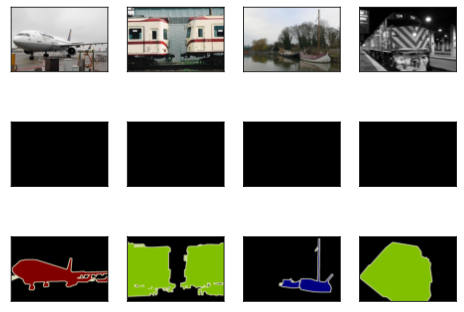

In [ ]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012') 
test_images, test_labels = d2l.read_voc_images(voc_dir, False) 
n, imgs = 4, []

for i in range(n):
  crop_rect = (0, 0, 320, 480)
  X = torchvision.transforms.functional.crop(test_images[i], *crop_rect) 
  pred = label2image(predict(X))
  imgs += [X.permute(1,2,0), pred.cpu(),
  torchvision.transforms.functional.crop( test_labels[i], *crop_rect).permute(1,2,0)]

d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);